<a href="https://colab.research.google.com/github/Sharath2021/-LIVE-CLASS-MONITORING-SYSTEM-Face-Emotion-Recognition-/blob/main/LIVE_CLASS_MONITORING_SYSTEM(Face_Emotion_Recognition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title : Face Emotion Recognition**
## **Introduction**

Emotion recognition is the process of identifying human emotion. People vary widely in their accuracy at recognizing the emotions of others. Use of technology to help people with emotion recognition is a relatively nascent research area. Generally, the technology works best if it uses multiple modalities in context. To date, the most work has been conducted on automating the recognition of facial expressions from video, spoken expressions from audio, written expressions from text, and physiology as measured by wearables.

Facial expressions are a form of nonverbal communication. Various studies have been done for the classification of these facial expressions. There is strong evidence for the universal facial expressions of seven emotions which include: neutral happy, sadness, anger, disgust, fear, and surprise. So it is very important to detect these emotions on the face as it has wide applications in the field of Computer Vision and Artificial Intelligence. These fields are researching on the facial emotions to get the sentiments of the humans automatically.

## **Problem Statement**
The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms. Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. 

Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge. In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to a lack of surveillance. 

While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analyzed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analyzed and tracked.

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.The solution to this problem is by recognizing facial emotions.

In [1]:
# Importing libraries

import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

# **Deep Face**

 

*   Deepface is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python.
*   The process of facial recognition starts with the human face and identifying its necessary facial features and patterns. A human face comprises a very basic set of features, such as eyes, nose, and mouth. Facial recognition technology learns what a face is and how it looks. This is done by using deep neural network & machine learning algorithms on a set of images with human faces looking at different angles or positions.





In [3]:
# installing deepface library
!pip install deepface


     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 2.3 MB 10.9 MB/s 
     |████████████████████████████████| 462 kB 50.2 MB/s 


## **Image Prediction using DeepFace**

In [4]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [11]:
path='/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/20200523_221751 (1).jpg'

In [12]:
img = cv2.imread(path)

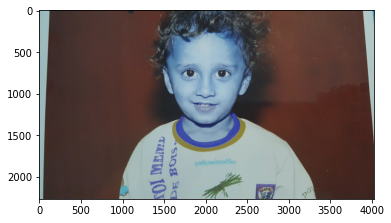

In [13]:
plt.imshow(img)

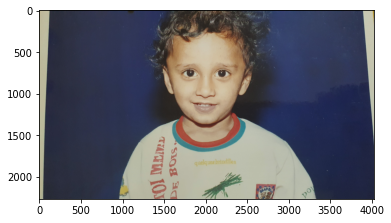

In [14]:
# convert image from BGR to RGB to work on RGB images
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [19]:
# image prediction
img_prediction = DeepFace.analyze(img)

Action: race: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


In [20]:
img_prediction

{'age': 23,
 'dominant_emotion': 'happy',
 'dominant_race': 'latino hispanic',
 'emotion': {'angry': 0.00536716943315696,
  'disgust': 5.333553598774188e-07,
  'fear': 0.021293910685926676,
  'happy': 94.60369348526001,
  'neutral': 3.6565646529197693,
  'sad': 0.01235612144228071,
  'surprise': 1.7007224261760712},
 'gender': 'Man',
 'race': {'asian': 5.72536513209343,
  'black': 4.009378328919411,
  'indian': 25.73709785938263,
  'latino hispanic': 33.33687484264374,
  'middle eastern': 17.311449348926544,
  'white': 13.8798326253891},
 'region': {'h': 1002, 'w': 1002, 'x': 1509, 'y': 378}}

**From deepface some predictions are not true i.e. my age is not accurate and even dominant_race predicted incorrect. So, we have to build another model for accuracy. We use CNN model below.**

In [4]:
#importing zip file
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/archive .zip'

In [5]:
# Extracting zip file

with ZipFile(file_name, 'r') as zip:
  zip.extractall(path='fer13')
  print('File extraction done')

File extraction done


In [6]:
#test and train data
test_data = '/content/fer13/test'
train_data = '/content/fer13/train'

In [7]:
#list the directory of test path
os.listdir(test_data)

['disgust', 'sad', 'surprise', 'angry', 'neutral', 'fear', 'happy']

In [8]:
#list the directory of train path
os.listdir(train_data)

['disgust', 'sad', 'surprise', 'angry', 'neutral', 'fear', 'happy']

In [9]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')


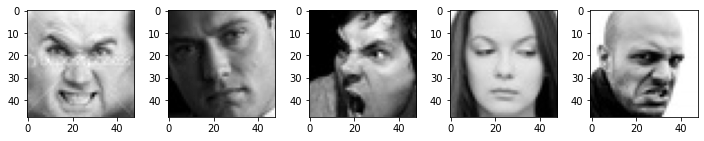

In [10]:
#sample images of angry class
plot_images(train_data+'/angry')

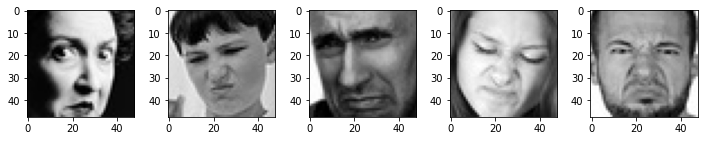

In [11]:
#sample images of disgust class
plot_images(train_data+'/disgust')

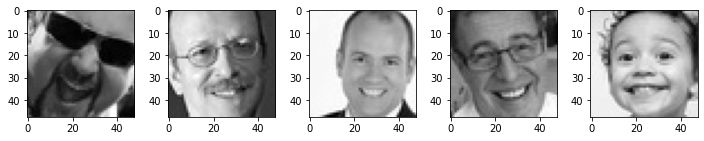

In [12]:
#sample of happy class
plot_images(train_data+'/happy')

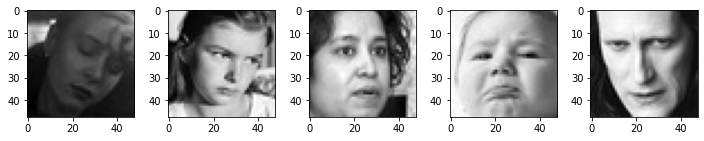

In [13]:
#sample of sad class
plot_images(train_data+'/sad')

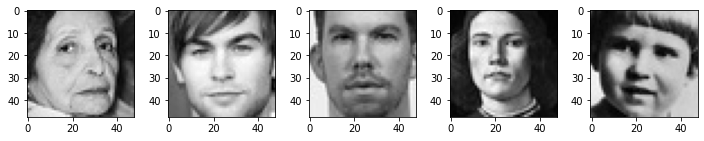

In [14]:
#sample of neutral class
plot_images(train_data+'/neutral')

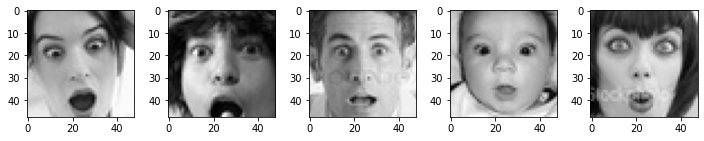

In [15]:
#sample of surprise class
plot_images(train_data+'/surprise')

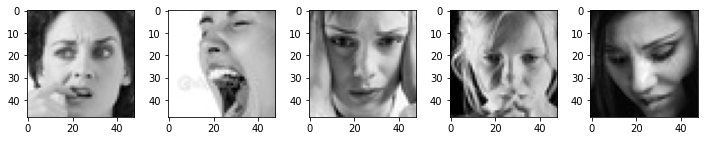

In [16]:
#sample of fear class
plot_images(train_data+'/fear')

In [17]:
# Reading input path

INPUT_PATH = "/content/fer13"

In [18]:
# specifying the image size we want to input in model

picture_size=48

In [19]:
# list of all the classes

classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [20]:
# finding the count of images in each category

category=[]
examples=[]
for i in classes:
    dir=INPUT_PATH + "/"+ 'train/'+i
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    category.append(i)
    examples.append(len(onlyfiles))

In [21]:
# creating a dataframe for the count of images

example_count_df=pd.DataFrame(category,columns=['Category'],index=[1,2,3,4,5,6,7])
example_count_df['No. of images']=examples
example_count_df

,Category,No. of images
1,angry,3995
2,disgust,436
3,fear,4097
4,happy,7215
5,neutral,4965
6,sad,4830
7,surprise,3171


Text(0.5, 1.0, 'Count of images in each category')

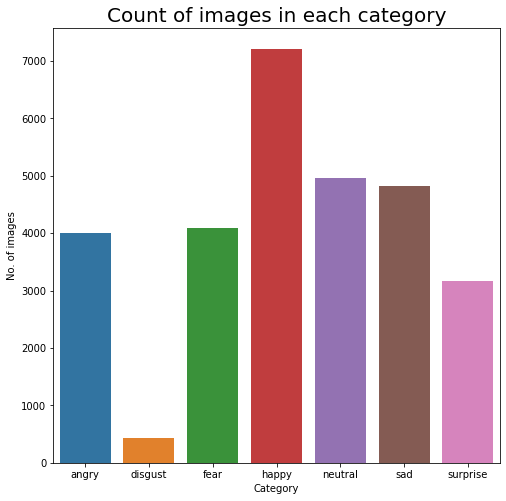

In [22]:
# visualizing

plt.figure(figsize=(8,8))
sns.barplot(x=example_count_df['Category'],y=example_count_df['No. of images'])
plt.title('Count of images in each category',fontsize=20)

In [23]:
# defining the train and test set 
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(INPUT_PATH + "/"+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(INPUT_PATH + "/"+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building the CNN Model**

*   A convolution network generally consists of alternate convolution and 
max-pooling operations. The output obtained after applying convolution operation is shrunk using max-pooling operation which is then used as an input for the next layer.

*   A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics. The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.

*   I chose Convolutional Neural Network(CNN) in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.

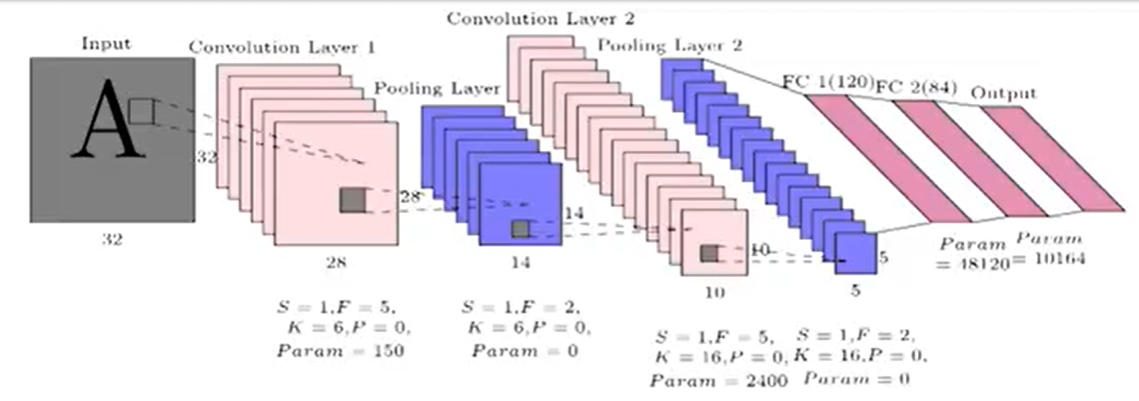




In [24]:
# defining a CNN model
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

**Defining my CNN with the following global architecture:**



1.   4 convolutional layers
2.   2 fully connected layers




**Basic CNN architecture details:**

Input layer - Input layer in CNN should contain image data
Convo layer - Convo layer is sometimes called feature extractor layer because features of the image are get extracted within this layer
Pooling layer - Pooling is used to reduce the dimensionality of each features while retaining the most important information. It is used between two convolution layer
Fully CL - Fully connected layer involves weights, biases, and neurons. It connects neurons in one layer to neurons in another layer. It is used to classify images between different category by training and placed before the output layer
Output Layer - Output layer contains the label which is in the form of one-hot encoded

**Also some common techniques used for each layer** 

1.**Batch normalization**: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.

2.**Dropout:** reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.


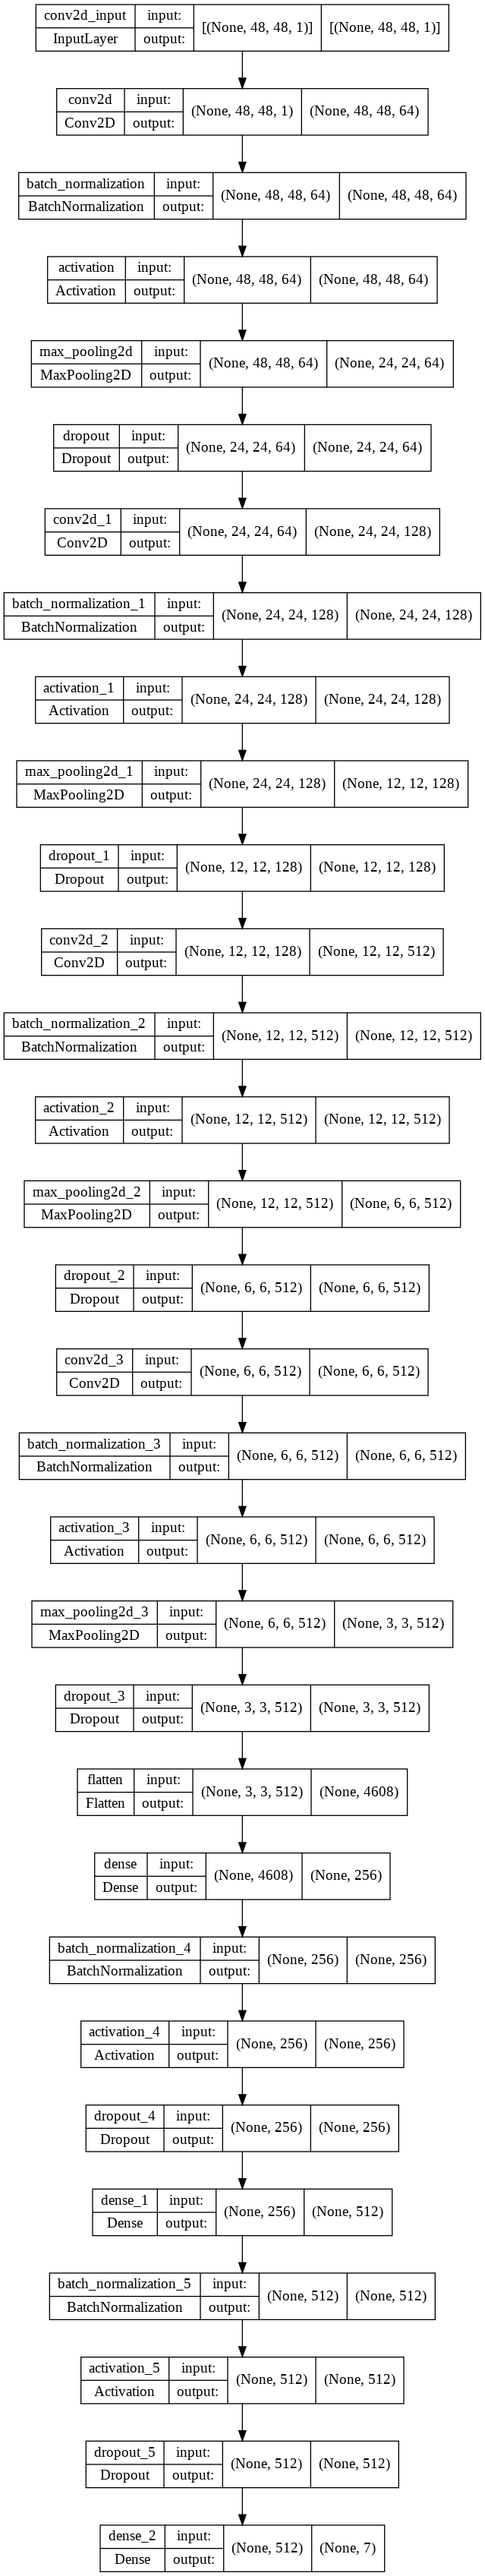

In [25]:
#Visualizing the model

tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png')

# **Training the model**

In [26]:
# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# defining no. of epoch
epochs = 40

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [27]:
# Fitting and training the model
history = model.fit(train_set,
                        epochs=epochs,
                        validation_data = test_set,
                        callbacks=callbacks_list
                        )

Epoch 1/40
225/225 [==============================] - ETA: 0s - loss: 1.8544 - accuracy: 0.2772
Epoch 1: val_accuracy improved from -inf to 0.24714, saving model to model.h5
225/225 [==============================] - 42s 134ms/step - loss: 1.8544 - accuracy: 0.2772 - val_loss: 2.0041 - val_accuracy: 0.2471
Epoch 2/40
225/225 [==============================] - ETA: 0s - loss: 1.5650 - accuracy: 0.3947
Epoch 2: val_accuracy improved from 0.24714 to 0.34397, saving model to model.h5
225/225 [==============================] - 30s 135ms/step - loss: 1.5650 - accuracy: 0.3947 - val_loss: 1.7314 - val_accuracy: 0.3440
Epoch 3/40
225/225 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.4560
Epoch 3: val_accuracy improved from 0.34397 to 0.48955, saving model to model.h5
225/225 [==============================] - 29s 127ms/step - loss: 1.4035 - accuracy: 0.4560 - val_loss: 1.3056 - val_accuracy: 0.4896
Epoch 4/40
225/225 [==============================] - ETA: 0s - loss: 

In [28]:
#saving the model
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/custom_model_result.h5')

In [29]:
# Predicting Test Set
predictions=model.predict(test_set)

In [40]:
# loading the saved model
trained_model=load_model('model.h5')


In [31]:
# evaluating the train set
trained_model.evaluate(train_set)

225/225 [==============================] - 22s 95ms/step - loss: 0.6598 - accuracy: 0.7507


[0.6597709059715271, 0.7506704926490784]

In [32]:
# evaluating the test set
trained_model.evaluate(test_set)

57/57 [==============================] - 3s 48ms/step - loss: 1.0098 - accuracy: 0.6519


[1.0097763538360596, 0.6518529057502747]

**Our best model managed to obtain a training accuracy of approximately 75.05% and testing accuracy of 65.19% on the dataset by running 40 epochs. which is quite good.**

**At each of the epochs, Keras checks if our model performed better than the models of the previous epochs.**

## **Confusion Matrix**

In [36]:
# Printing the Confusion Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_set.classes)                                 
cm

array([[ 524,    6,   72,   41,  101,  201,   13],
       [  24,   53,    5,    2,    7,   17,    3],
       [  89,    4,  427,   31,  124,  285,   64],
       [  32,    1,   32, 1465,  134,   83,   27],
       [  52,    1,   41,   59,  796,  274,   10],
       [  90,    0,   79,   43,  196,  825,   14],
       [  26,    2,  117,   38,   29,   30,  589]])

<Figure size 432x288 with 0 Axes>

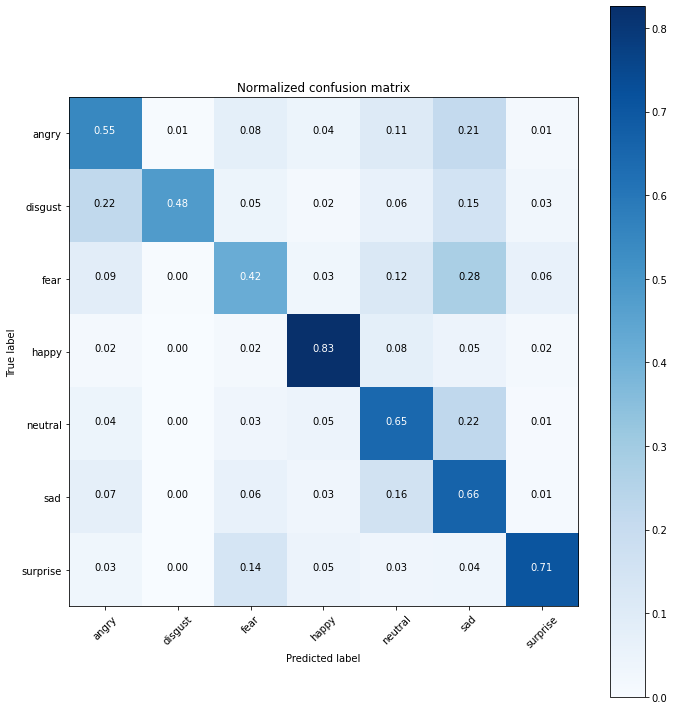

In [38]:
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# **Plotting Accuracy & Loss to analyze the results**

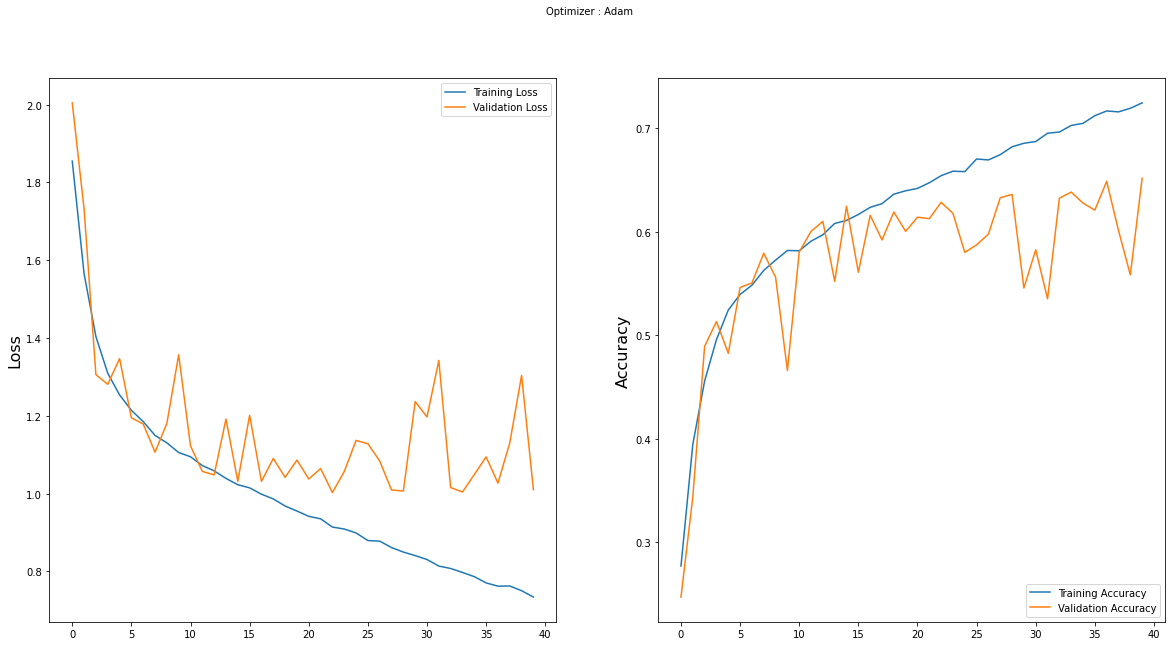

In [37]:
# plotting the Loss for training and validation set
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**The training loss is slightly higher than the validation loss for the first epochs.**

# **Conclusion**

*   Our model is giving an accuracy of 75.05% in training and 65.19% in testing, it is robust, works well in a dim light environment as well. 


*   The application is able to detect face and predict the right expression while checking it on a webcam(localhost).


*   The front-end of the model was made using streamlit for webapp and running well on local webapp link.

*   Finally, we successfully deployed the Streamlit WebApp on Heroku and Streamlit share that runs on a web server.



*   Finally, through this monitoring system teachers can analyze the students' change in emotions during online classes and address the problems faced my students and change their way of teaching if necessary.






